# Numerical methods - Integrating over 3D source patterns

Computing the RX power for TX-RX configurations requires integrating over the 3D TX radiation pattern. This can be done in multiple ways, where the most convenient (fast simulating) method would be using a closed-form expression for the integral, and the relatively slow but sure way would be numerical integration. 

For real TX units (radially asymmetric, not Lambertian), we don't even have closed-form expressions for the patterns themselves (we just have look-up tables (LUT)). For such units we have no choice but to numerically integrate the pattern LUT.

For radially symmetric Lambertian patterns, we do have closed-form expressions for the pattern:

<br> 

<center> $\cos^{m} \left(\sqrt{ \theta^2 + \varphi^2} \right)$</center>
 
where m is the Lambertian order and $\theta$ and $\varphi$ are the zy and xy angles respectively. Note that this is simply the revolved version of the 2D pattern around the nominal axis, i.e., the pattern is completely defined with a single "abstract" angle: $\phi=\sqrt{ \theta^2 + \varphi^2}$. However, even though we have the closed-form pattern expression, we don't have a closed-form integral expression for this. Therefore, we use one of the following two methods to compute the integral:

- when the limits of the integration (i.e. for $\theta$ and $\varphi$) form very small intervals in both zy and xy axes, the portion of the lambertian pattern staying within these angle intervals is a rectangular prism with a "wavy" top that only lumps in a single direction, i.e., the gradient is also smooth. Since the top of the prism is smooth, we can assume the top is close to being a linear slump that is so smooth, it's nearly a rectangular prism with height = average height of the four corners of the wavy top. **This is fast, but inaccurate when the interval gets larger**


- when the limits of the integration form large intervals though, the assumption above isn't valid anymore since the prism top lumps way too non-linearly to consider just an average value as the height. In this case we need to numerically compute the integral. **This is slower, but does not lose accuracy as the interval gets larger**


In this notebook we show how the two methods behave with respect to each other in a typical simulation scenario for a radially symmetric lambertian pattern.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### get trajectory

In [2]:
a = np.load('../../trajectories/utilities/generated_lanechange.npz')

In [3]:
L = 1.6 # vehicle width in meters, check below
print("vehicle width, check: ", np.sqrt((a['x_RR']-a['x_RL'])**2+(a['y_RR']-a['y_RL'])**2)[0])
xRL_to_rxL = a['x_RL']
yRL_to_rxL = a['y_RL']
xRR_to_rxL = a['x_RR']
yRR_to_rxL = a['y_RR']
xRL_to_rxR = a['x_RL'] - L
yRL_to_rxR = a['y_RL']
xRR_to_rxR = a['x_RR'] - L
yRR_to_rxR = a['y_RR']
hdg  = a['hdg']

vehicle width, check:  1.6


### get optics

In [4]:
a = np.load('../../optics/qrx_planoconvex.npz')

In [5]:
f_QRX    = a['f_QRX']
pd_snst  = a['tia_gamma']
pd_gain  = a['tia_R_F']
pd_dim   = a['detecting_area'] # square detector dimension in milimeters.

In [6]:
a = np.load('../../optics/tx_lambertian_20deg_2W.npz')

In [7]:
tx_ha   = a['half_angle']
tx_pwr  = a['power']
tx_norm = a['normalization_factor']
tx_lambertian_order = int(-np.log(2)/np.log(np.cos(np.deg2rad(tx_ha))));

### get angles

In [8]:
def tx_solidangles(x, y, z, dim):
    # note that axis xz is not used since roads are assumed to be flat
    psi1_xy = np.arctan2(y,x + dim/2);
    psi2_xy = np.arctan2(y,x - dim/2);
    psi3_xy = psi2_xy - psi1_xy;
    eps1_xy = np.rad2deg((np.deg2rad(90)-psi2_xy));
    eps2_xy = np.rad2deg(np.deg2rad(eps1_xy) + psi3_xy);

    psi1_zy = np.arctan2(y,z + dim/2);
    psi2_zy = np.arctan2(y,z - dim/2);
    psi3_zy = psi2_zy - psi1_zy;
    eps1_zy = np.rad2deg((np.deg2rad(90)-psi2_zy));
    eps2_zy = np.rad2deg(np.deg2rad(eps1_zy) + psi3_zy);
    
    return eps1_xy, eps2_xy, eps1_zy, eps2_zy

### method 1 - approximate with rectangular prism of average height

In [9]:
def received_power(x, y, z, dim, tx_pwr, tx_norm, tx_lambertian_order):
    # the portion of the lambertian pattern staying within these angles is a rectangular prism with a "wavy" top. 
    # prism is smooth though, + we always check veeery small solidangle portions, so we can assume
    # the top is close to being a linear slump that is so smooth, it's nearly a rectangular prism
    # with height = average height of the four corners. This should bring very small error. 
    angles = tx_solidangles(x, y, z, dim)
    #angles = (eps1_xy, eps2_xy, eps1_zy, eps2_zy)
        
    # since the pattern is radially symmetric, we can keep just one (x,y) pattern, 
    # where the x values can be computed as such, using xy and zy angles (think Pythagorean):
    pattern_angle_xy1_zy1 = np.sqrt(angles[0]**2 + angles[2]**2)
    pattern_angle_xy1_zy2 = np.sqrt(angles[0]**2 + angles[3]**2)
    pattern_angle_xy2_zy1 = np.sqrt(angles[1]**2 + angles[2]**2)
    pattern_angle_xy2_zy2 = np.sqrt(angles[1]**2 + angles[3]**2)
    
    val_xy1_zy1 = np.cos(np.deg2rad(pattern_angle_xy1_zy1))**tx_lambertian_order # lambertian
    val_xy1_zy2 = np.cos(np.deg2rad(pattern_angle_xy1_zy2))**tx_lambertian_order # lambertian
    val_xy2_zy1 = np.cos(np.deg2rad(pattern_angle_xy2_zy1))**tx_lambertian_order # lambertian
    val_xy2_zy2 = np.cos(np.deg2rad(pattern_angle_xy2_zy2))**tx_lambertian_order # lambertian
    
    # length and width of the prism
    angle_dist_xy = np.abs(angles[0] - angles[1])
    angle_dist_zy = np.abs(angles[2] - angles[3])

    # average height of the prism
    avg_val = (val_xy1_zy1 + val_xy1_zy2 + val_xy2_zy1 + val_xy2_zy2)/4 # average height of that rectangular prism with wavy top
    
    pwr = tx_pwr*angle_dist_xy*angle_dist_zy*avg_val/tx_norm;

    return pwr

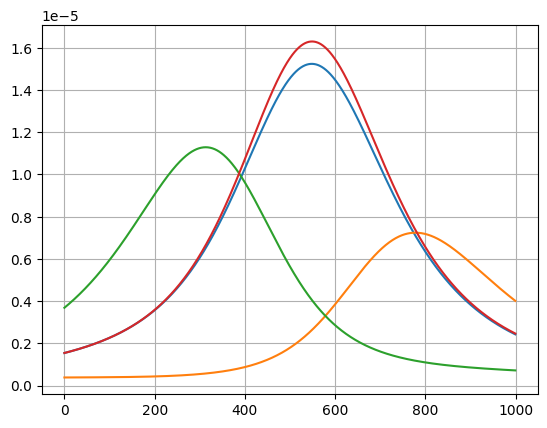

In [10]:
pwr_txL_to_rxL1 = received_power(xRL_to_rxL, yRL_to_rxL, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order)
pwr_txL_to_rxR1 = received_power(xRL_to_rxR, yRL_to_rxR, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order)
pwr_txR_to_rxL1 = received_power(xRR_to_rxL, yRR_to_rxL, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order)
pwr_txR_to_rxR1 = received_power(xRR_to_rxR, yRR_to_rxR, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order)

fig, ax = plt.subplots()
ax.plot(pwr_txL_to_rxL1)
ax.plot(pwr_txL_to_rxR1)
ax.plot(pwr_txR_to_rxL1)
ax.plot(pwr_txR_to_rxR1)
ax.grid()
plt.show()

### method 2 - numerical integral over radially symmetric pattern

In [11]:
power      = 2.0;  # [W]
half_angle = 20.0; # [deg]

angle_sweep_resolution = 0.001; # [deg]
# enlarge square array (by sqrt(2)x) so that the integrator doesn't hit bounds
angle_sweep_high       =  90*np.sqrt(2)
angle_sweep_low        = -90*np.sqrt(2)
angle_sweep_numsamples = int(((angle_sweep_high - angle_sweep_low)/angle_sweep_resolution))
angle_sweep_array_sqr  = np.linspace(angle_sweep_low, angle_sweep_high, num=angle_sweep_numsamples)

lambertian_order = np.round(-np.log(2)/np.log(np.cos(np.deg2rad(half_angle))));
pattern          = np.cos(np.deg2rad(angle_sweep_array_sqr))**lambertian_order;
pattern_indexed  = np.concatenate((np.expand_dims(angle_sweep_array_sqr, axis=0), np.expand_dims(pattern, axis=0)), axis=0)

In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def radSymSrc3dIntegral( rad_pat, eps1_xy, eps2_xy, eps1_zy, eps2_zy ):
    id0_eps1_xy = find_nearest(rad_pat[0,:], eps1_xy);
    id0_eps2_xy = find_nearest(rad_pat[0,:], eps2_xy);
    id0_eps1_zy = find_nearest(rad_pat[0,:], eps1_zy);
    id0_eps2_zy = find_nearest(rad_pat[0,:], eps2_zy);

    id_zero = int(rad_pat.shape[1]/2); # works because python is 0 indexed
    
    id_list_numsamples_xy = int(abs(id0_eps2_xy-id0_eps1_xy)+1);
    id_list_numsamples_zy = int(abs(id0_eps2_zy-id0_eps1_zy)+1);
    
    id_list_fwd_xy = np.linspace(id0_eps2_xy, id0_eps1_xy, num=id_list_numsamples_xy);
    id_list_bwd_xy = np.linspace(id0_eps1_xy, id0_eps2_xy, num=id_list_numsamples_xy);
    id_list_fwd_zy = np.linspace(id0_eps2_zy, id0_eps1_zy, num=id_list_numsamples_zy);
    id_list_bwd_zy = np.linspace(id0_eps1_zy, id0_eps2_zy, num=id_list_numsamples_zy);
    
    # note that the same rectangular prism of average height approximation in method1 is also done below, 
    # but here it's done on a sample-by-sample basis, not for an angle interval. So here it is done 
    # to sort of over-sample the LUT that we generate using the pattern expression.

    vol_fwd = 0;
    for i in range(1, id_list_numsamples_xy): # i=2:length(id_list_fwd_xy)
        for j in range(1, id_list_numsamples_zy): # j=2:length(id_list_fwd_zy)
            radial_pos_i_xy_i_zy     = int(np.sqrt((id_list_fwd_xy[i] - id_zero)**2 + (id_list_fwd_zy[j] - id_zero)**2))
            radial_pos_im1_xy_i_zy   = radial_pos_i_xy_i_zy-1; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            radial_pos_i_xy_im1_zy   = radial_pos_i_xy_i_zy-1; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            radial_pos_im1_xy_im1_zy = radial_pos_i_xy_i_zy-2; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            avg_y_val = (rad_pat[1,radial_pos_i_xy_i_zy+id_zero] + \
                rad_pat[1,radial_pos_im1_xy_i_zy+id_zero] + \
                rad_pat[1,radial_pos_i_xy_im1_zy+id_zero] + \
                rad_pat[1,radial_pos_im1_xy_im1_zy+id_zero] )/4 ;
            vol_fwd = vol_fwd + (rad_pat[0,radial_pos_i_xy_i_zy+id_zero]-rad_pat[0,radial_pos_im1_xy_i_zy+id_zero])* \
                (rad_pat[0,radial_pos_i_xy_i_zy+id_zero]-rad_pat[0,radial_pos_i_xy_im1_zy+id_zero])* \
                avg_y_val;

    vol_bwd = 0;
    for i in range(1, id_list_numsamples_xy): # i=2:length(id_list_bwd_xy)
        for j in range(1, id_list_numsamples_zy): # j=2:length(id_list_bwd_zy)
            radial_pos_i_xy_i_zy     = int(np.sqrt((id_list_bwd_xy[i] - id_zero)**2 + (id_list_bwd_zy[j] - id_zero)**2))
            radial_pos_im1_xy_i_zy   = radial_pos_i_xy_i_zy-1; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            radial_pos_i_xy_im1_zy   = radial_pos_i_xy_i_zy-1; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            radial_pos_im1_xy_im1_zy = radial_pos_i_xy_i_zy-2; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            avg_y_val = (rad_pat[1,radial_pos_i_xy_i_zy+id_zero] + \
                rad_pat[1,radial_pos_im1_xy_i_zy+id_zero] + \
                rad_pat[1,radial_pos_i_xy_im1_zy+id_zero] + \
                rad_pat[1,radial_pos_im1_xy_im1_zy+id_zero] )/4 ;
            vol_bwd = vol_bwd + (rad_pat[0,radial_pos_i_xy_i_zy+id_zero]-rad_pat[0,radial_pos_im1_xy_i_zy+id_zero])* \
                (rad_pat[0,radial_pos_i_xy_i_zy+id_zero]-rad_pat[0,radial_pos_i_xy_im1_zy+id_zero])* \
                avg_y_val;

    # we compensate the above approximations by averaging forward and backward passes, 
    # based on the fact that the curve we're doing this on is very smooth. So just improving
    # the oversampling process with an average over neighbor samples (and their gradients actually).
    vol = (vol_fwd+vol_bwd)/2;
    return vol

100%|███████████████████████████████████████| 1000/1000 [03:00<00:00,  5.53it/s]


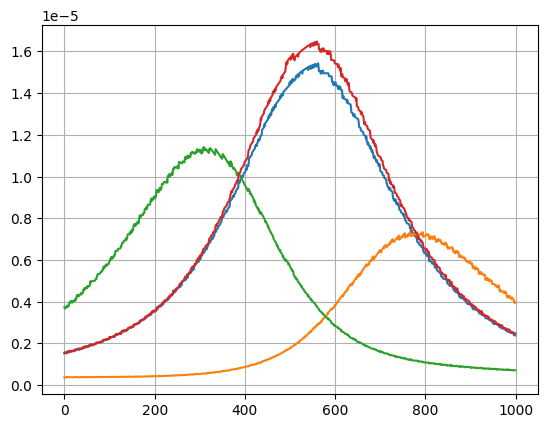

In [13]:
pwr_txL_to_rxL2 = []
pwr_txL_to_rxR2 = []
pwr_txR_to_rxL2 = []
pwr_txR_to_rxR2 = []
for i in tqdm(range(0,1000)):
    eps1_xy, eps2_xy, eps1_zy, eps2_zy = tx_solidangles(xRL_to_rxL[i], yRL_to_rxL[i], 0, pd_dim/1000)
    vol = radSymSrc3dIntegral( pattern_indexed, eps1_xy, eps2_xy, eps1_zy, eps2_zy);
    pwr_txL_to_rxL2.append(tx_pwr*vol/tx_norm);

    eps1_xy, eps2_xy, eps1_zy, eps2_zy = tx_solidangles(xRL_to_rxR[i], yRL_to_rxR[i], 0, pd_dim/1000)
    vol = radSymSrc3dIntegral( pattern_indexed, eps1_xy, eps2_xy, eps1_zy, eps2_zy);
    pwr_txL_to_rxR2.append(tx_pwr*vol/tx_norm)

    eps1_xy, eps2_xy, eps1_zy, eps2_zy = tx_solidangles(xRR_to_rxL[i], yRR_to_rxL[i], 0, pd_dim/1000)
    vol = radSymSrc3dIntegral( pattern_indexed, eps1_xy, eps2_xy, eps1_zy, eps2_zy);
    pwr_txR_to_rxL2.append(tx_pwr*vol/tx_norm);

    eps1_xy, eps2_xy, eps1_zy, eps2_zy = tx_solidangles(xRR_to_rxR[i], yRR_to_rxR[i], 0, pd_dim/1000)
    vol = radSymSrc3dIntegral( pattern_indexed, eps1_xy, eps2_xy, eps1_zy, eps2_zy);
    pwr_txR_to_rxR2.append(tx_pwr*vol/tx_norm);
    
fig, ax = plt.subplots()
ax.plot(pwr_txL_to_rxL2)
ax.plot(pwr_txL_to_rxR2)
ax.plot(pwr_txR_to_rxL2)
ax.plot(pwr_txR_to_rxR2)
ax.grid()
plt.show()

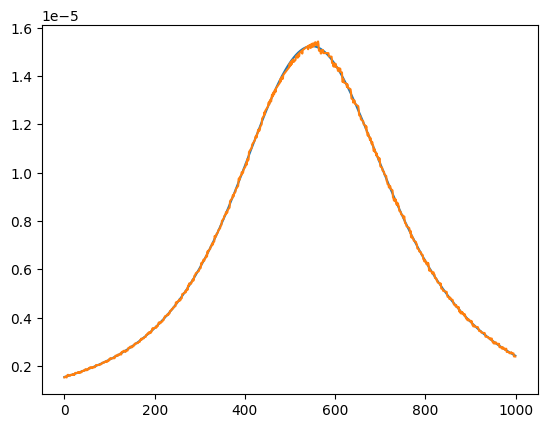

In [14]:
fig, ax = plt.subplots()
ax.plot(pwr_txL_to_rxL1)
ax.plot(pwr_txL_to_rxL2)

### method 3 - numerical integral over a pattern that is not radially symmetric

This emerged after the review, to capture non-lambertian real headlight patterns. We can ofcourse process the symmetric one the same way, and that's what we will do here to prove that we're on the right track (we'll see if this new method produces the same output as the previous cases)

In [15]:
power      = 2.0;  # [W]
half_angle = 20.0; # [deg]

angle_sweep_resolution = 0.03; # [deg]
# enlarge square array (by sqrt(2)x) so that the integrator doesn't hit bounds
angle_sweep_high       =  90*np.sqrt(2)
angle_sweep_low        = -90*np.sqrt(2)
angle_sweep_numsamples = int(((angle_sweep_high - angle_sweep_low)/angle_sweep_resolution))
angle_sweep_array_sqr  = np.linspace(angle_sweep_low, angle_sweep_high, num=angle_sweep_numsamples)

lambertian_order = np.round(-np.log(2)/np.log(np.cos(np.deg2rad(half_angle))));

mesh_phi, mesh_theta = np.meshgrid(angle_sweep_array_sqr, angle_sweep_array_sqr)

def get2dlambertian(phi,theta, order):
    angle = np.sqrt(phi**2 + theta**2)
    return np.cos(np.deg2rad(angle))**order

pattern = get2dlambertian(mesh_phi, mesh_theta, lambertian_order)

In [16]:
# ref: https://stackoverflow.com/a/23734295
def find_k_nearest(array, value, k):
    array = np.asarray(array)
    vals  = np.abs(array - value)
    idx   = vals.argsort()[:k]
    #idx   = idx[np.argsort(vals[idx])]
    return idx

In [17]:
def getinterp(y2,y1,x2,x1,xnew):
    return (xnew-x1)*(y2-y1)/(x2-x1)+y1

def asymmetricSrc3dIntegral_smallangle( pat, phi_anglearray, theta_anglearray, eps1_xy, eps2_xy, eps1_zy, eps2_zy ):
    ids_eps1_xy   = find_k_nearest(phi_anglearray, eps1_xy, 2) # we get 2 values since an exact hit is improbable
    idtop_eps1_xy = ids_eps1_xy.max() # closest top point
    idbot_eps1_xy = ids_eps1_xy.min() # closest bottom point
    eps1_xy_top = phi_anglearray[idtop_eps1_xy]
    eps1_xy_bot = phi_anglearray[idbot_eps1_xy]
    
    # same for other 3 quantities
    ids_eps2_xy   = find_k_nearest(phi_anglearray, eps2_xy, 2);
    idtop_eps2_xy = ids_eps2_xy.max()
    idbot_eps2_xy = ids_eps2_xy.min()
    eps2_xy_top = phi_anglearray[idtop_eps2_xy]
    eps2_xy_bot = phi_anglearray[idbot_eps2_xy]
    
    ids_eps1_zy   = find_k_nearest(theta_anglearray, eps1_zy, 2);
    idtop_eps1_zy = ids_eps1_zy.max()
    idbot_eps1_zy = ids_eps1_zy.min()
    eps1_zy_top = theta_anglearray[idtop_eps1_zy]
    eps1_zy_bot = theta_anglearray[idbot_eps1_zy]
    
    ids_eps2_zy   = find_k_nearest(theta_anglearray, eps2_zy, 2);
    idtop_eps2_zy = ids_eps2_zy.max()
    idbot_eps2_zy = ids_eps2_zy.min()
    eps2_zy_top = theta_anglearray[idtop_eps2_zy]
    eps2_zy_bot = theta_anglearray[idbot_eps2_zy]
    
    # first compute the interp heights on the two sides of the plane,
    # then use their height vals for a final interp over the other axis.
    eps1xy1zy_z_bot_bot = pat[idbot_eps1_xy, idbot_eps1_zy]
    eps1xy1zy_z_bot_top = pat[idbot_eps1_xy, idtop_eps1_zy]
    eps1xy1zy_z_top_bot = pat[idtop_eps1_xy, idbot_eps1_zy]
    eps1xy1zy_z_top_top = pat[idtop_eps1_xy, idtop_eps1_zy]
    eps1xy1zy_z_interp_right = getinterp(eps1xy1zy_z_top_top, eps1xy1zy_z_top_bot, 
                                         eps1_zy_top, eps1_zy_bot, eps1_zy)
    eps1xy1zy_z_interp_left  = getinterp(eps1xy1zy_z_bot_top, eps1xy1zy_z_bot_bot, 
                                         eps1_zy_top, eps1_zy_bot, eps1_zy)
    eps1xy1zy_z_interp_final = getinterp(eps1xy1zy_z_interp_right, eps1xy1zy_z_interp_left, 
                                         eps1_xy_top, eps1_xy_bot, eps1_xy)

    # repeat for the other 3 eps points  
    eps1xy2zy_z_bot_bot = pat[idbot_eps1_xy, idbot_eps2_zy]
    eps1xy2zy_z_bot_top = pat[idbot_eps1_xy, idtop_eps2_zy]
    eps1xy2zy_z_top_bot = pat[idtop_eps1_xy, idbot_eps2_zy]
    eps1xy2zy_z_top_top = pat[idtop_eps1_xy, idtop_eps2_zy]
    eps1xy2zy_z_interp_right = getinterp(eps1xy2zy_z_top_top, eps1xy2zy_z_top_bot, 
                                         eps2_zy_top, eps2_zy_bot, eps2_zy)
    eps1xy2zy_z_interp_left  = getinterp(eps1xy2zy_z_bot_top, eps1xy2zy_z_bot_bot, 
                                         eps2_zy_top, eps2_zy_bot, eps2_zy)
    eps1xy2zy_z_interp_final = getinterp(eps1xy2zy_z_interp_right, eps1xy2zy_z_interp_left, 
                                         eps1_xy_top, eps1_xy_bot, eps1_xy)

    eps2xy1zy_z_bot_bot = pat[idbot_eps2_xy, idbot_eps1_zy]
    eps2xy1zy_z_bot_top = pat[idbot_eps2_xy, idtop_eps1_zy]
    eps2xy1zy_z_top_bot = pat[idtop_eps2_xy, idbot_eps1_zy]
    eps2xy1zy_z_top_top = pat[idtop_eps2_xy, idtop_eps1_zy]
    eps2xy1zy_z_interp_right = getinterp(eps2xy1zy_z_top_top, eps2xy1zy_z_top_bot, 
                                         eps1_zy_top, eps1_zy_bot, eps1_zy)
    eps2xy1zy_z_interp_left  = getinterp(eps2xy1zy_z_bot_top, eps2xy1zy_z_bot_bot, 
                                         eps1_zy_top, eps1_zy_bot, eps1_zy)
    eps2xy1zy_z_interp_final = getinterp(eps2xy1zy_z_interp_right, eps2xy1zy_z_interp_left, 
                                         eps2_xy_top, eps2_xy_bot, eps2_xy)
    
    eps2xy2zy_z_bot_bot = pat[idbot_eps2_xy, idbot_eps2_zy]
    eps2xy2zy_z_bot_top = pat[idbot_eps2_xy, idtop_eps2_zy]
    eps2xy2zy_z_top_bot = pat[idtop_eps2_xy, idbot_eps2_zy]
    eps2xy2zy_z_top_top = pat[idtop_eps2_xy, idtop_eps2_zy]
    eps2xy2zy_z_interp_right = getinterp(eps2xy2zy_z_top_top, eps2xy2zy_z_top_bot, 
                                         eps2_zy_top, eps2_zy_bot, eps2_zy)
    eps2xy2zy_z_interp_left  = getinterp(eps2xy2zy_z_bot_top, eps2xy2zy_z_bot_bot, 
                                         eps2_zy_top, eps2_zy_bot, eps2_zy)
    eps2xy2zy_z_interp_final = getinterp(eps2xy2zy_z_interp_right, eps2xy2zy_z_interp_left, 
                                         eps2_xy_top, eps2_xy_bot, eps2_xy)
    
    vol = (eps2_xy - eps1_xy)*(eps2_zy - eps1_zy) * \
          (eps1xy1zy_z_interp_final + eps1xy2zy_z_interp_final +\
           eps2xy1zy_z_interp_final + eps2xy2zy_z_interp_final)/4
    
    return vol

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 143.39it/s]


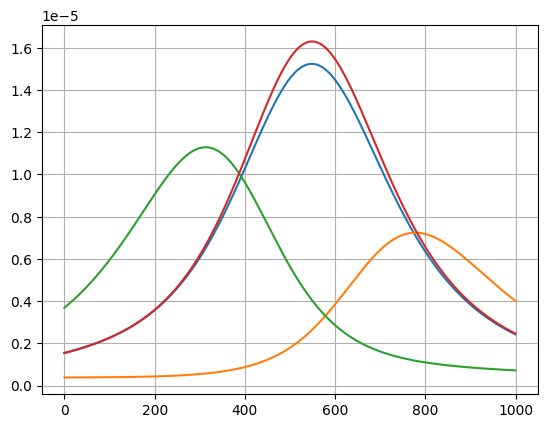

In [18]:
pwr_txL_to_rxL3 = []
pwr_txL_to_rxR3 = []
pwr_txR_to_rxL3 = []
pwr_txR_to_rxR3 = []
for i in tqdm(range(0,1000)):
    eps1_xy, eps2_xy, eps1_zy, eps2_zy = tx_solidangles(xRL_to_rxL[i], yRL_to_rxL[i], 0, pd_dim/1000)
    vol = asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                             eps1_xy, eps2_xy, eps1_zy, eps2_zy)
    pwr_txL_to_rxL3.append(tx_pwr*vol/tx_norm);

    eps1_xy, eps2_xy, eps1_zy, eps2_zy = tx_solidangles(xRL_to_rxR[i], yRL_to_rxR[i], 0, pd_dim/1000)
    vol = asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                             eps1_xy, eps2_xy, eps1_zy, eps2_zy)
    pwr_txL_to_rxR3.append(tx_pwr*vol/tx_norm)

    eps1_xy, eps2_xy, eps1_zy, eps2_zy = tx_solidangles(xRR_to_rxL[i], yRR_to_rxL[i], 0, pd_dim/1000)
    vol = asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                             eps1_xy, eps2_xy, eps1_zy, eps2_zy)
    pwr_txR_to_rxL3.append(tx_pwr*vol/tx_norm);

    eps1_xy, eps2_xy, eps1_zy, eps2_zy = tx_solidangles(xRR_to_rxR[i], yRR_to_rxR[i], 0, pd_dim/1000)
    vol = asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                             eps1_xy, eps2_xy, eps1_zy, eps2_zy)
    pwr_txR_to_rxR3.append(tx_pwr*vol/tx_norm);
    
fig, ax = plt.subplots()
ax.plot(pwr_txL_to_rxL3)
ax.plot(pwr_txL_to_rxR3)
ax.plot(pwr_txR_to_rxL3)
ax.plot(pwr_txR_to_rxR3)
ax.grid()
plt.show()

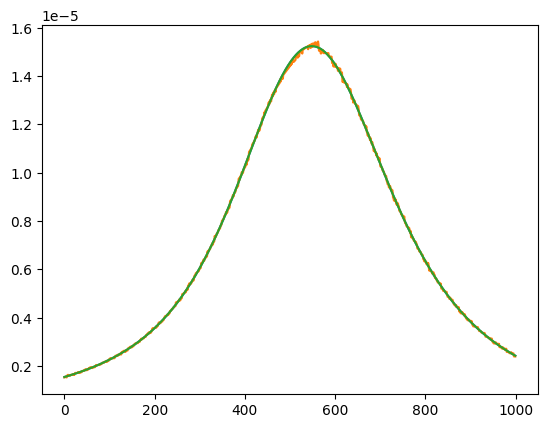

In [19]:
fig, ax = plt.subplots()
ax.plot(pwr_txL_to_rxL1)
ax.plot(pwr_txL_to_rxL2)
ax.plot(pwr_txL_to_rxL3)

In [20]:
(pwr_txL_to_rxL1 - pwr_txL_to_rxL3).max()

7.269621031855784e-12

### method 4 - a version of method 3 that works on large angle intervals

we test this on a sweep of the pattern rather than from samples on the example trajectory

In [21]:
def asymmetricSrc3dIntegral_largeangle(pat, phi_anglearray, theta_anglearray, eps1_xy, eps2_xy, eps1_zy, eps2_zy):
    id0_eps1_xy = find_nearest(phi_anglearray, eps1_xy);
    id0_eps2_xy = find_nearest(phi_anglearray, eps2_xy);
    id0_eps1_zy = find_nearest(theta_anglearray, eps1_zy);
    id0_eps2_zy = find_nearest(theta_anglearray, eps2_zy);
    
    id_list_numsamples_xy = int(abs(id0_eps2_xy-id0_eps1_xy)+1);
    id_list_numsamples_zy = int(abs(id0_eps2_zy-id0_eps1_zy)+1);
    
    id_list_fwd_xy = np.linspace(id0_eps2_xy, id0_eps1_xy, num=id_list_numsamples_xy).astype(int);
    id_list_fwd_zy = np.linspace(id0_eps2_zy, id0_eps1_zy, num=id_list_numsamples_zy).astype(int);
    vol = 0;
    for i in range(1, id_list_numsamples_xy): # i=2:length(id_list_fwd_xy)
        for j in range(1, id_list_numsamples_zy): # j=2:length(id_list_fwd_zy)
            new_vol = asymmetricSrc3dIntegral_smallangle(pat, phi_anglearray, theta_anglearray, 
                                                         phi_anglearray[id_list_fwd_xy[i-1]], 
                                                         phi_anglearray[id_list_fwd_xy[i]], 
                                                         theta_anglearray[id_list_fwd_zy[j-1]], 
                                                         theta_anglearray[id_list_fwd_zy[j]])
            vol = vol + new_vol;

    return vol

In [22]:
print(asymmetricSrc3dIntegral_largeangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -0.05, 0.05, -0.05, 0.05))
print(asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -0.05, 0.05, -0.05, 0.05))
print(radSymSrc3dIntegral(pattern_indexed, -0.05, 0.05, -0.05, 0.05)) # reference

0.0144042849351915
0.00999990952450019
0.009801085283765366


In [23]:
print(asymmetricSrc3dIntegral_largeangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -0.1, 0.1, -0.1, 0.1))
print(asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -0.1, 0.1, -0.1, 0.1))
print(radSymSrc3dIntegral(pattern_indexed, -0.1, 0.1, -0.1, 0.1)) # reference

0.032409478158855226
0.03999863291207544
0.03960101998583569


In [24]:
print(asymmetricSrc3dIntegral_largeangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -0.2, 0.2, -0.2, 0.2))
print(asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -0.2, 0.2, -0.2, 0.2))
print(radSymSrc3dIntegral(pattern_indexed, -0.2, 0.2, -0.2, 0.2)) # reference

0.17644450634642928
0.15997844889086427
0.15919580366487585


In [25]:
print(asymmetricSrc3dIntegral_largeangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -0.5, 0.5, -0.5, 0.5))
print(asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -0.5, 0.5, -0.5, 0.5))
print(radSymSrc3dIntegral(pattern_indexed, -0.5, 0.5, -0.5, 0.5)) # reference

1.0404113975208735
0.9991619597944807
0.9977354745789195


In [26]:
print(asymmetricSrc3dIntegral_largeangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -1, 1, -1, 1))
print(asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -1, 1, -1, 1))
print(radSymSrc3dIntegral(pattern_indexed, -1, 1, -1, 1)) # reference

3.9172911719587105
3.986615263374923
3.9916006798164134


In [27]:
print(asymmetricSrc3dIntegral_largeangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -5, 5, -5, 5))
print(asymmetricSrc3dIntegral_smallangle(pattern, angle_sweep_array_sqr, angle_sweep_array_sqr, 
                                         -5, 5, -5, 5))
print(radSymSrc3dIntegral(pattern_indexed, -5, 5, -5, 5)) # reference

97.665487302342
91.94460147432436
97.24164849398093


### conclusions:

- don't use the full-blown numerical integration (method2) for small intervals because it creates an unnecessary jitter which of course doesn't exist in the physical setup (there is no noise here). Theoretically speaking, we could increase the angle resolution of the numerical integration method to make that jitter reaaally small, but that would just make it impractically slow.

- use method1 numerical approximation for small intervals, since, as seen by the last graph, the full-blown numerical integration method converges to that one as the angle resolution of the LUT gets finer. It's immeasurably faster than method2 for this task, and the inaccuracy is not important for our applications as long as the result is smooth (and it is)

- use numerical integration (method2) for computing the normalization factor of the whole LUT since the approximation in method1 only holds for small intervals, and the whole LUT is ofcourse -90$^\circ$ to +90$^\circ$. Also, the angular resolution does not have to be super-high there since the LUT is reaally smooth! 

- numerical integration on asymmetric patterns also works as expected, so we can use that for computing integrals over real patterns.

- HOWEVER NOTE THAT method 3 would only work at runtime since it can only handle short angular intervals (linear interp assumption), it cannot possibly compute normalization factors on large intervals. That would require a modification that makes iterative computations over consecutive short intervals to emulate the large interval. See method 4 for that modification.

- note how method 2 and method 4 converges for larger angle intervals and method 3 gets worse. This is expected since the lambertian pattern is of course not linear between -10 and +10 degrees and method 3 assumes they are linear. Method 4 is much faster than method 2, so it makes more sense to use that one instead while computing tx normalization factors